In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import re
import csv
import json
from spellchecker import SpellChecker
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
import torch
print(torch.cuda.is_available())  # Doit renvoyer True

False


In [2]:
# Download a sample
document_name = "Cash-Payment-Receipt-Template.pdf"
doc = DocumentFile.from_pdf("dataset/"+document_name)

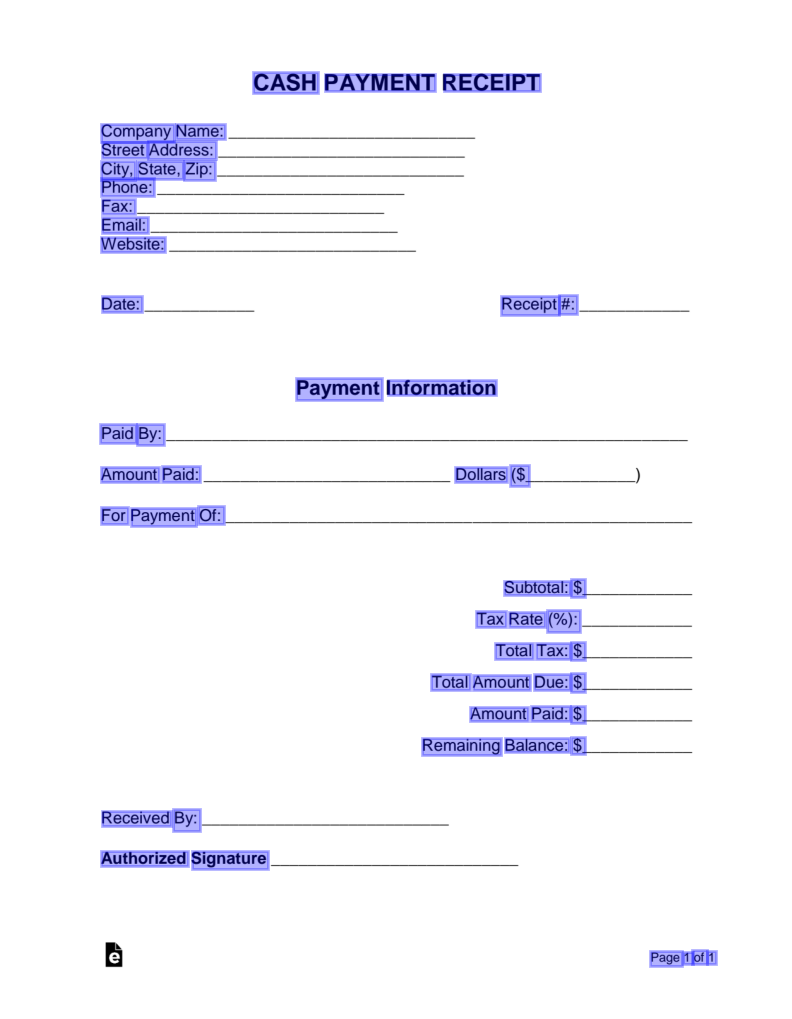

In [3]:
predictor = ocr_predictor(det_arch='db_resnet50', reco_arch='vitstr_small', pretrained=True)
# Déplacer sur GPU si disponible
if torch.cuda.is_available():
    predictor.cuda().half()
result = predictor(doc)
result.show()

# Create dataset images

In [20]:
import os
import numpy as np
import cv2

def extract_and_save_words(result, doc, output_dir="extracted_words/images"):
    """
    Extrait les mots d'un document OCRisé, les sauvegarde sous forme d'images individuelles,
    et retourne un dictionnaire {chemin_de_l'image: "label"}.

    Args:
        result: Résultat de l'OCR (ex: output de DocTR).
        doc: Document image ou tensor (ex: output de DocTR pour les images).
        output_dir: Dossier où sauvegarder les images extraites.
    """
    os.makedirs(output_dir, exist_ok=True)
    image_and_labels = {}  # Dictionnaire à remplir

    for page_idx, (page, img) in enumerate(zip(result.pages, doc)):
        # Conversion en numpy array si nécessaire
        if not isinstance(img, np.ndarray):
            img = np.array(img)

        height, width = img.shape[:2]
        for block_idx, block in enumerate(page.blocks):
            for line_idx, line in enumerate(block.lines):
                for word_idx, word in enumerate(line.words):
                    # Conversion des coordonnées normalisées
                    x_min, y_min = word.geometry[0]
                    x_max, y_max = word.geometry[1]
                    x_min = int(x_min * width)
                    y_min = int(y_min * height)
                    x_max = int(x_max * width)
                    y_max = int(y_max * height)

                    # Crop du mot
                    word_crop = img[y_min:y_max, x_min:x_max]

                    # Définir le chemin de sauvegarde
                    save_path = os.path.join(
                        output_dir,
                        f"page{page_idx}_block{block_idx}_line{line_idx}_word{word_idx}.png"
                    )

                    # Sauvegarder l'image
                    cv2.imwrite(save_path, cv2.cvtColor(word_crop, cv2.COLOR_RGB2BGR))

                    # Ajouter au dictionnaire
                    save_path = os.path.split(save_path)[-1]
                    image_and_labels[save_path] = word.value  # 'value' contient le texte du mot

    return image_and_labels

In [21]:
def natural_key(string_):
    """Clé de tri naturel : sépare lettres et chiffres."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', string_)]

def sort_dict_naturally(dico):
    sorted_keys = sorted(dico.keys(), key=natural_key)
    sorted_dict = {key: dico[key] for key in sorted_keys}
    return sorted_dict

In [22]:
#extract_and_save_words(result, doc)
image_and_labels = extract_and_save_words(result, doc)
image_and_labels = sort_dict_naturally(image_and_labels)

# Create images CSV

In [ ]:
def save_dict_to_csv(image_and_labels, csv_path):
    """
    Sauvegarde un dictionnaire {chemin_image: label} dans un fichier CSV.

    Args:
        image_and_labels: Dictionnaire à sauvegarder.
        csv_path: Chemin du fichier CSV à créer.
    """
    with open(csv_path, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        
        # Écrire chaque ligne
        for image_path, label in image_and_labels.items():
            writer.writerow([image_path, label])
    print(f"Les chemins des images et leurs labels ont été enregistrés dans {csv_path}")

In [28]:
# Exemple d'utilisation
output_csv_file = "extracted_words/labels.csv"
save_dict_to_csv(image_and_labels, output_csv_file)

# Create JSON


In [35]:
def save_image_labels_to_json(image_and_labels, json_path):
    """
    Sauvegarde le dictionnaire image_and_labels dans un fichier JSON.

    Args:
        image_and_labels: Dictionnaire {chemin_image: label}.
        json_path: Chemin du fichier JSON à créer.
    """
    # Trier les clés du dictionnaire naturellement
    sorted_keys = sorted(image_and_labels.keys(), key=natural_key)
    
    # Créer un dictionnaire trié
    sorted_image_and_labels = {key: image_and_labels[key] for key in sorted_keys}
    
    # Sauvegarder dans un fichier JSON
    with open(json_path, mode='w', encoding='utf-8') as json_file:
        json.dump(sorted_image_and_labels, json_file, indent=4, ensure_ascii=False)
    
    print(f"Les chemins des images et leurs labels ont été enregistrés dans {json_path}")

In [36]:
# Exemple d'utilisation
input_directory = "extracted_words/images"
json_path_file = "extracted_words/labels.json"
save_image_labels_to_json(image_and_labels, json_path=json_path_file)

Les chemins des images et leurs labels ont été enregistrés dans extracted_words/labels.json


# CSV to JSON

In [ ]:
def convert_excel_to_json(input_csv, json_path):
    data = {}

    # Lire le fichier CSV
    with open(input_csv, mode='r', encoding='utf-8') as csv_file:
        reader = csv.reader(csv_file, delimiter=';')
        for row in reader:
            if len(row) >= 2:
                file_name, label = row[0].strip(), row[1].strip()
                data[file_name] = label

    # Sauvegarder en JSON
    with open(json_path, mode='w', encoding='utf-8') as json_file:
        json.dump(data, json_file, indent=4, ensure_ascii=False)

    print(f"Le fichier JSON a été créé : {json_path}")

In [ ]:
input_csv = "extracted_words/labels.csv"
json_path = "extracted_words/labels.json"
convert_excel_to_json(input_csv, json_path)

Le fichier JSON a été créé : extracted_words/images.json


Manually, label each image

# Correct typo

In [ ]:
def correct_spelling(word, language='fr'):
    """
    Fonction pour corriger une erreur typographique dans un mot.
    Utilise le correcteur orthographique pyspellchecker.
    """
    spell = SpellChecker(language=language)  # Langue française
    corrected_word = spell.correction(word)
    return corrected_word

def process_csv(input_csv, output_csv, language='fr'):
    """
    Lit un fichier CSV, corrige les erreurs typographiques dans la 2ème colonne,
    puis enregistre un nouveau fichier CSV avec les corrections.

    Args:
        input_csv: Chemin du fichier CSV en entrée.
        output_csv: Chemin du fichier CSV en sortie avec les corrections.
    """
    # Ouvrir le fichier CSV en lecture
    with open(input_csv, mode='r', encoding='utf-8') as infile:
        reader = csv.reader(infile, delimiter=';')
        rows = list(reader)

    # Traiter chaque ligne (en supposant que la première ligne est l'entête)
    for i, row in enumerate(rows):
        if i == 0:  # Ignorer l'en-tête
            continue
        
        image_path = row[0]  # La première colonne est le chemin de l'image
        predicted_word = row[1]  # La deuxième colonne est le mot prédit
        
        # Corriger le mot prédit s'il contient une erreur typographique
        if predicted_word:
            corrected_word = correct_spelling(predicted_word, language)
            row[1] = corrected_word  # Remplacer le mot par la correction

    # Ouvrir le fichier CSV en écriture pour sauvegarder les corrections
    with open(output_csv, mode='w', newline='', encoding='utf-8') as outfile:
        writer = csv.writer(outfile, delimiter=';')
        
        # Écrire l'en-tête
        writer.writerow(rows[0])
        
        # Écrire les lignes corrigées
        writer.writerows(rows[1:])

    print(f"Le fichier CSV corrigé a été enregistré sous : {output_csv}")

In [42]:
# Exemple d'utilisation
csv_file = "extracted_words/labels_SAVE.csv"
corrected_csv = "extracted_words/labels_corrected_SAVE.csv"
process_csv(csv_file, corrected_csv, language='fr')

Le fichier CSV corrigé a été enregistré sous : extracted_words/labels_corrected_SAVE.csv
